# Load Dependencies

In [109]:
%%capture
import pandas as pd, pprint, sys, requests, numpy as np, matplotlib.pyplot as plt
import json, re, ast
import seaborn as sns
plt.style.use('ggplot')
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from pysal.lib import examples
from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')
pd.set_option('display.max_columns', None)
import uuid
from scipy import stats


# Variables

In [2]:
path = 'C:/Users/wonch/OneDrive/Escritorio/Projects/Prueba Tecnica DD360/reto1/'
raw_csv = path+'raw_data/reto_precios.csv'

cdmx_shape = path+'cdmx_map/nyu_2451_36855.shp'
alcaldias_shape = path+'poligonos_alcaldias_cdmx/poligonos_alcaldias_cdmx.shp'
alcaldiasv2_shape = path+'poligonos_alcaldias_cdmx_update/poligonos_alcaldias_cdmx.shp'
ageb_shape = path+'poligono_ageb_urbanas_cdmx/poligono_ageb_urbanas_cdmx.shp'
ids_ageb = path+'raw_data/ids_ageb.csv'

# Data INEGI

INEGI Data containing DENUE and AGEBs information
Using INEGIpy library for ease of access to INEGI API *(https://github.com/andreslomeliv/DatosMex/tree/master/INEGIpy#AGEBs)*

In [3]:
from INEGIpy import MarcoGeoestadistico
marco = MarcoGeoestadistico()
cdmx = '09'
alcaldias = ['015','014','016','010']

In [4]:
type(marco.AGEBs(claves_concatenadas=cdmx+alcaldias[1]))

geopandas.geodataframe.GeoDataFrame

In [5]:
%%time
df_agebs = gpd.GeoDataFrame()
for i in alcaldias:
  ageb = marco.AGEBs(claves_concatenadas=cdmx+i)
  df_agebs = pd.concat([df_agebs,ageb])

CPU times: total: 141 ms
Wall time: 10 s


# Data Wrangling

In [6]:
df = pd.read_csv(raw_csv)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             981 non-null    object 
 1   subtitle              981 non-null    object 
 2   link                  981 non-null    object 
 3   location              981 non-null    object 
 4   price                 981 non-null    object 
 5   attributes            981 non-null    object 
 6   timestamp             981 non-null    object 
 7   id                    981 non-null    int64  
 8   address               702 non-null    object 
 9   since                 981 non-null    object 
 10  description           981 non-null    object 
 11  vendor                981 non-null    object 
 12  lat                   981 non-null    float64
 13  lon                   981 non-null    float64
 14  price_mod             981 non-null    float64
 15  price_currency        9

In [8]:
df.shape

(981, 35)

In [9]:
df.columns

Index(['main_name', 'subtitle', 'link', 'location', 'price', 'attributes',
       'timestamp', 'id', 'address', 'since', 'description', 'vendor', 'lat',
       'lon', 'price_mod', 'price_currency', 'since_period', 'since_value',
       'days_on_site', 'amenities', 'age_in_years', 'bathrooms', 'cellars',
       'num_floors', 'monthly_fee', 'apartments_per_floor', 'disposition',
       'parking_lots', 'floor_situated', 'orientation', 'num_bedrooms',
       'department_type', 'm2', 'final_price', 'price_square_meter'],
      dtype='object')

In [10]:
df.head(3)

,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,description,vendor,lat,lon,price_mod,price_currency,since_period,since_value,days_on_site,amenities,age_in_years,bathrooms,cellars,num_floors,monthly_fee,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,Garden house con 2 habitaciones y dos baños c...,Investemx,19.421317,-99.164182,9000000.0,pesos,days,5,5.0,3.0,0.0,2.0,NaN,1.0,0 MXN,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,2,Tonala,Publicado hace 7 días,Mezcla perfecta entre E S T I L O y C A L I D ...,Avitana,19.421029,-99.163541,4264000.0,pesos,days,7,7.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1.0,NaN,54.0,4264000.0,78962.962963
2,Townhouse Único En La Roma Sur,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",8093500 pesos,"163 m² construidos,3 recs.",2022-03-29,3,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",Publicado hace 4 días,"Concepto único en Roma Sur, es un desarrollo d...",Ebranuncios,19.407814,-99.161872,8093500.0,pesos,days,4,4.0,NaN,0.0,3.0,2.0,3.0,NaN,NaN,NaN,2,NaN,NaN,3.0,NaN,163.0,8093500.0,49653.374233


In [11]:
df[['lat','lon']].describe()

,lat,lon
count,981.000000,981.000000
mean,19.654796,-99.222834
std,1.244009,0.608650
min,19.360533,-117.063962
25%,19.405824,-99.165172
50%,19.411515,-99.163637
75%,19.419526,-99.161332
max,32.528726,-99.128642


#### Ample deveation on latitude and longitude columns min and max decimal degrees variate greatly so the coordinates are very far appart from each other.
#### For easy manipulation plot the data and see where they're geographically located

<Axes: >

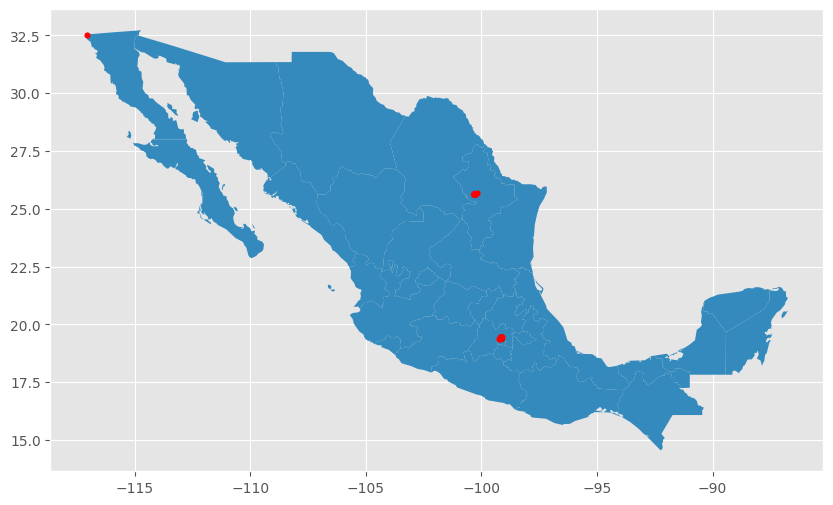

In [12]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(examples.get_path("mexicojoin.shp"))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

# Not everything is in CDMX - There are stuff in TJ and MTY.
### Hence there's a hardcut at lat > -100 and lon < 20 for accurate data manipulation
##### Here onwards the analysis will be focused using the mexican INEGI data (National Institute of Statistics and Geography) which has mapped the country and created 

In [13]:
df_cdmx = df[(df['lat']>-100)&(df['lat']<20)]

<Axes: >

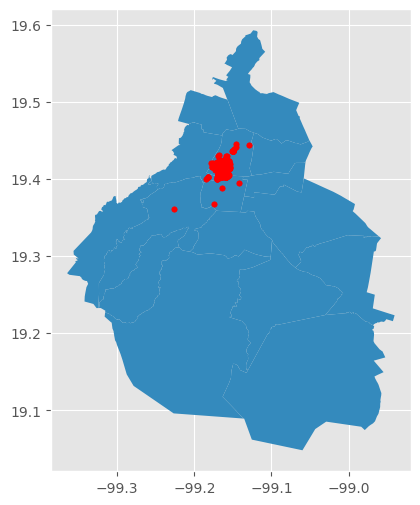

In [14]:
geometry = [Point(xy) for xy in zip(df_cdmx['lon'], df_cdmx['lat'])]
gdf = GeoDataFrame(df_cdmx, geometry=geometry)
world = gpd.read_file(alcaldias_shape)
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

<Axes: >

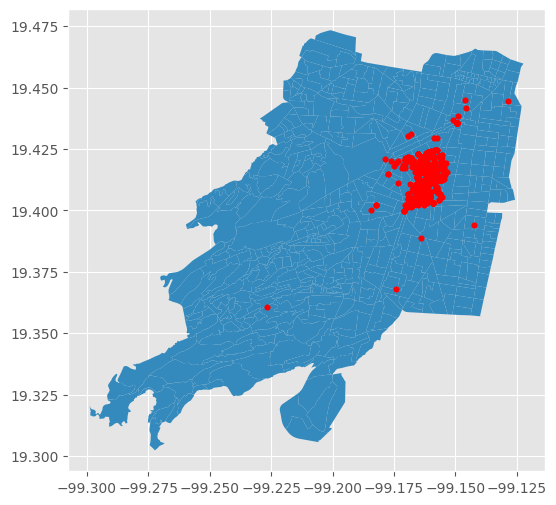

In [15]:
geometry = [Point(xy) for xy in zip(df_cdmx['lon'], df_cdmx['lat'])]
gdf = GeoDataFrame(df_cdmx, geometry=geometry)
gdf.plot(ax=df_agebs.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

<Axes: >

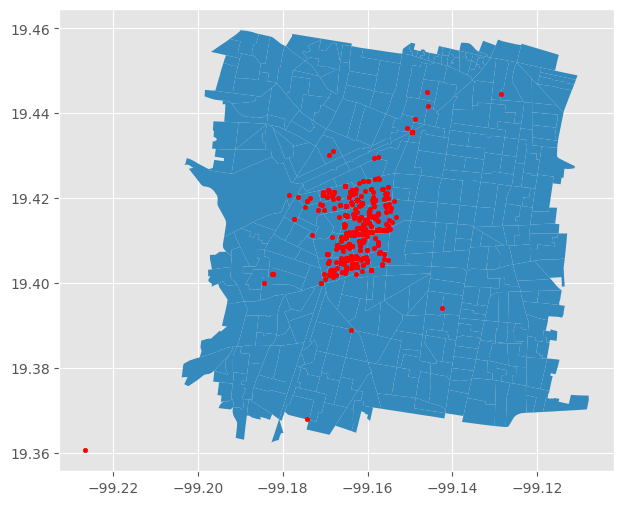

In [16]:
geometry = [Point(xy) for xy in zip(df_cdmx['lon'], df_cdmx['lat'])]
gdf = GeoDataFrame(df_cdmx, geometry=geometry)
world = gpd.read_file(ageb_shape)
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=10)

# Alcaldías where the properties are located:


*   Cuahutemoc
*   Benito Juarez<sup>*</sup>
*   Miguel Hidalgo<sup>*</sup>
*   Alvaro Obregon<sup>**</sup>

<sup>*</sup>A scattered set of properties in these areas, might bring noise but relevant for statistical significancy. \
<sup>**</sup>This property could be potentially treated like an outlier, it's pretty far away from the rest of the other properties and might cause noise when analyzing.

*Pública, A. D. de I. (n.d.). Portal de Datos Abiertos de la CDMX. https://datos.cdmx.gob.mx/dataset/alcaldias/resource/8648431b-4f34-4f1a-a4b1-19142f944300*

In [17]:
%%time

def is_point_inside_polygon(point, polygon):
    return polygon.contains(point)

result_data = {'geometry': [], 'properties': []}
result_df = pd.DataFrame(result_data)

for _, polygon_row in df_agebs.iterrows():
    polygon_id = polygon_row['cvegeo']
    polygon = polygon_row['geometry']
    point_count = 0

    # Check if any points are inside the current polygon
    for _, point_row in df_cdmx.iterrows():
        point = Point(point_row['lon'], point_row['lat'])
        if is_point_inside_polygon(point, polygon):
            point_count += 1

    # Append the polygon and point count to the result DataFrame
    result_df = pd.concat([result_df, pd.DataFrame({'geometry': [polygon], 'properties': [point_count]})], ignore_index=True)

result_df = gpd.GeoDataFrame(result_df, geometry='geometry', crs='EPSG:4326')

CPU times: total: 35.9 s
Wall time: 35.9 s


<Axes: >

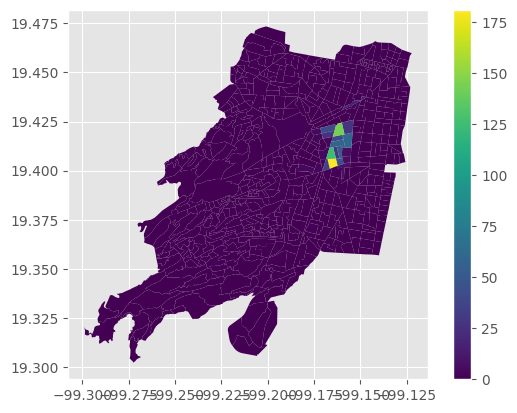

In [18]:
result_df.plot(column='properties', legend=True)

<Axes: >

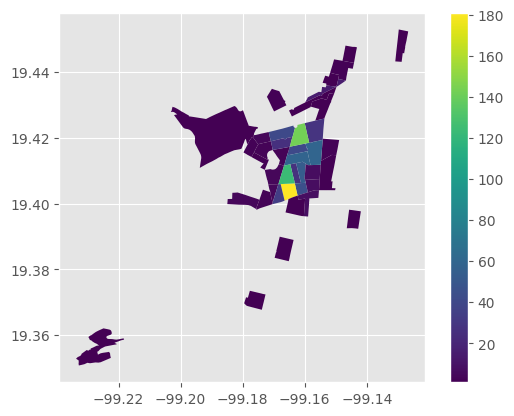

In [19]:
result_df[result_df['properties']>0].plot(column='properties', legend=True)

# The properties are located in a few selected AGEBs.
### Helped by the INEGI data the analysis will have more information relevant to the AGEBs and the city such as
*   Wholesale and retail stores
*   Information and Educational services
*   Health Services
*   Recreative Services
*   Parks and Gardens

In [20]:
def check_containment(df_cdmx, df_agebs): 
    df_cdmx.loc[:, ('nom_agem')] = ''
    df_cdmx.loc[:, ('ageb_id')] = ''
    
    dfagebs_gdf = gpd.GeoDataFrame(df_agebs, geometry='geometry')

    dfagebs_gdf.sindex

    for index, point in df_cdmx.iterrows():
        p = Point(point['lon'], point['lat'])  # Create a Shapely Point object

        # Find the polygons that contain the point
        possible_matches_index = list(dfagebs_gdf.sindex.intersection(p.bounds))
        possible_matches = dfagebs_gdf.iloc[possible_matches_index]

        # Check containment
        for _, polygon in possible_matches.iterrows():
            if polygon['geometry'].contains(p):
                df_cdmx.at[index, 'nom_agem'] = polygon['nom_agem']
                df_cdmx.at[index, 'ageb_id'] = polygon['cvegeo']
                break  # Stop checking if a match is found

    return df_cdmx

In [22]:
%%time
df_cdmx = check_containment(df_cdmx, df_agebs)

CPU times: total: 1.34 s
Wall time: 1.36 s


In [23]:
df_alcaldias = pd.DataFrame({'agem_id': ['09' + i for i in alcaldias],
                   'nom_agem': ['Cuauhtémoc','Benito Juárez','Miguel Hidalgo','Álvaro Obregón']})


In [24]:
df_cdmx = pd.merge(df_cdmx, df_alcaldias, on='nom_agem', how='left')

In [25]:
from INEGIpy import DENUE
token_inegi = '6955b94a-bdcf-4194-ac91-ec259c517551'
denue = DENUE(token_inegi)

In [26]:
df_actividades = pd.DataFrame({'actividades': ['431','433','461','462','464','611','7131'],
                   'act_name': ['wholesale','retailshop','supermarket','conveniency_shop',
                                'pharmacy','schools','recreative_installation']})

In [27]:
%%time
df_denue_act = denue.Cuantificar(clave_area = df_alcaldias['agem_id'].tolist(),
                       clave_actividad = df_actividades['actividades'].tolist(), estrato= '1') 

CPU times: total: 15.6 ms
Wall time: 26.5 s


In [28]:
df_denue_merge = pd.merge(df_denue_act, df_actividades, left_on='AE', right_on='actividades', how='left')
df_denue_merge = df_denue_merge[['AG','act_name','Total']].pivot(index='AG', columns='act_name', values='Total').reset_index()

In [40]:
df_denue_merge

act_name,AG,conveniency_shop,pharmacy,recreative_installation,retailshop,schools,supermarket,wholesale
0,09010,52,542,64,28,245,5085,48
1,09014,64,416,12,71,194,2065,51
2,09015,113,1387,75,438,264,4578,83
3,09016,38,398,22,47,96,2760,62


In [146]:
df_cdmx_danue = pd.merge(df_cdmx, df_denue_merge, left_on='agem_id', right_on='AG', how='left')

In [147]:
df_cdmx_danue.head(1)

,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,description,vendor,lat,lon,price_mod,price_currency,since_period,since_value,days_on_site,amenities,age_in_years,bathrooms,cellars,num_floors,monthly_fee,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter,nom_agem,ageb_id,agem_id,AG,conveniency_shop,pharmacy,recreative_installation,retailshop,schools,supermarket,wholesale
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,Garden house con 2 habitaciones y dos baños c...,Investemx,19.421317,-99.164182,9000000.0,pesos,days,5,5.0,3.0,0.0,2.0,NaN,1.0,0 MXN,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732,Cuauhtémoc,0901500010998,09015,09015,113,1387,75,438,264,4578,83


In [148]:
pd.unique(df_cdmx_danue.price_currency)

array(['pesos'], dtype=object)

In [149]:
pd.unique(df_cdmx_danue.age_in_years)

array([0.])

In [150]:
def extract_numerical_area(df, column):
    pattern = r'(\d+) MXN'
    df[column + '_extracted'] = df[column].str.extract(pattern, expand=False)
    df[column + '_extracted'] = pd.to_numeric(df[column + '_extracted'])
    return df

In [151]:
df_cdmx_danue = extract_numerical_area(df_cdmx_danue,'monthly_fee')

In [152]:
# check for missing values
total = df_cdmx_danue.isnull().sum().sort_values(ascending=False)
percent = (df_cdmx_danue.isnull().sum()/df_cdmx_danue.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent of missing'])
missing_data.head(20)

,Total,Percent of missing
orientation,936,0.991525
apartments_per_floor,929,0.984110
disposition,925,0.979873
floor_situated,920,0.974576
department_type,905,0.958686
cellars,892,0.944915
num_floors,864,0.915254
monthly_fee,825,0.873941
monthly_fee_extracted,825,0.873941
amenities,462,0.489407


# Fields where data is missed in >90% of the cases can have a great impact in features.

In [153]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['orientation','apartments_per_floor','disposition','floor_situated','department_type','cellars',
               'num_floors','monthly_fee_extracted','amenities', 'address','age_in_years']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_cdmx_danue[col].fillna(0,inplace=True)
    df_cdmx_danue[col].fillna(0,inplace=True)

In [154]:
# check for missing values after treatment
total = df_cdmx_danue.isnull().sum().sort_values(ascending=False)
percent = (df_cdmx_danue.isnull().sum()/df_cdmx_danue.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent of missing'])
missing_data.head(20)

,Total,Percent of missing
monthly_fee,825,0.873941
main_name,0,0.000000
nom_agem,0,0.000000
disposition,0,0.000000
parking_lots,0,0.000000
floor_situated,0,0.000000
orientation,0,0.000000
num_bedrooms,0,0.000000
department_type,0,0.000000
m2,0,0.000000


In [155]:
numerical_feats = df_cdmx_danue.dtypes[df_cdmx_danue.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_cdmx_danue.dtypes[df_cdmx_danue.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  19
Number of Categorical features:  28


In [156]:
#Treatement for PCA make the ageb_id an integer
df_cdmx_danue['ageb_id'] = df_cdmx_danue['ageb_id'].replace('[A-Z]', '', regex=True)

In [157]:
df_cdmx_danue.head(1)

,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,description,vendor,lat,lon,price_mod,price_currency,since_period,since_value,days_on_site,amenities,age_in_years,bathrooms,cellars,num_floors,monthly_fee,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter,nom_agem,ageb_id,agem_id,AG,conveniency_shop,pharmacy,recreative_installation,retailshop,schools,supermarket,wholesale,monthly_fee_extracted
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,Garden house con 2 habitaciones y dos baños c...,Investemx,19.421317,-99.164182,9000000.0,pesos,days,5,5.0,3.0,0.0,2.0,0.0,1.0,0 MXN,0.0,Contrafrente,2,0.0,0,2.0,0,127.0,9000000.0,70866.141732,Cuauhtémoc,0901500010998,09015,09015,113,1387,75,438,264,4578,83,0.0


# PCA Analysis to understand the relationship of variables to price

In [158]:
['Oeste', 'Sur', 'Poniente', 'Norte', 'Oriente']

['Oeste', 'Sur', 'Poniente', 'Norte', 'Oriente']

In [159]:
#making all categorical variables consistent
df_cdmx_danue.loc[df_cdmx_danue['orientation'] == 0, 'orientation'] = ''
df_cdmx_danue.loc[df_cdmx_danue['department_type'] == 0, 'department_type'] = ''

In [160]:
# create a uuid for each property
df_cdmx_danue['uuid'] = df_cdmx_danue.apply(lambda _: uuid.uuid4(), axis=1)

In [161]:
df_cdmx_danue.columns

Index(['main_name', 'subtitle', 'link', 'location', 'price', 'attributes',
       'timestamp', 'id', 'address', 'since', 'description', 'vendor', 'lat',
       'lon', 'price_mod', 'price_currency', 'since_period', 'since_value',
       'days_on_site', 'amenities', 'age_in_years', 'bathrooms', 'cellars',
       'num_floors', 'monthly_fee', 'apartments_per_floor', 'disposition',
       'parking_lots', 'floor_situated', 'orientation', 'num_bedrooms',
       'department_type', 'm2', 'final_price', 'price_square_meter',
       'nom_agem', 'ageb_id', 'agem_id', 'AG', 'conveniency_shop', 'pharmacy',
       'recreative_installation', 'retailshop', 'schools', 'supermarket',
       'wholesale', 'monthly_fee_extracted', 'uuid'],
      dtype='object')

In [162]:
correlations_list = list()
target = 'final_price'
list_num_feats = list(numerical_feats)
list_not_plot = ['uuid', 'final_price']
list_plot_num_feats = [c for c in list(numerical_feats) if c not in list_not_plot]

for i in range(0,len(list_plot_num_feats)):
    stp = stats.pearsonr(df_cdmx_danue[list_plot_num_feats[i]], df_cdmx_danue[target])
    correlations_list.append([list_plot_num_feats[i],stp[0],stp[1]])
            
numeric_correlations = pd.DataFrame(data=correlations_list ,columns=["variable","r","p"])
numeric_correlations.sort_values(by="r", ascending=False, inplace=True)
numeric_correlations.reset_index(drop=True, inplace=True)

C:\Users\wonch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [163]:
# age_in_years is an empty col therefore it will cause noise and has no statistic significance
# price_mod has a 1 correlation the the price which could be related to being the same variable, hence it'll be dropped
numeric_correlations

,variable,r,p
0,price_mod,1.000000,0.000000e+00
1,parking_lots,0.514746,5.412448e-65
2,price_square_meter,0.399123,2.076956e-37
3,num_bedrooms,0.396804,5.867321e-37
4,bathrooms,0.348847,2.118798e-28
5,amenities,0.247312,1.272599e-14
6,days_on_site,0.139589,1.675759e-05
7,m2,0.121255,1.882020e-04
8,floor_situated,0.075724,1.997416e-02
9,monthly_fee_extracted,0.040539,2.133495e-01


In [164]:
df_cdmx_danue.drop('age_in_years', axis=1, inplace=True)
df_cdmx_danue.drop('price_mod', axis=1, inplace=True)

In [165]:
numerical_feats = df_cdmx_danue.dtypes[df_cdmx_danue.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_cdmx_danue.dtypes[df_cdmx_danue.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  17
Number of Categorical features:  29


In [166]:
#re-do the correlation of numerical values to target variable
correlations_list = list()
target = 'final_price'
list_num_feats = list(numerical_feats)
list_not_plot = ['uuid', 'final_price']
list_plot_num_feats = [c for c in list(numerical_feats) if c not in list_not_plot]

for i in range(0,len(list_plot_num_feats)):
    stp = stats.pearsonr(df_cdmx_danue[list_plot_num_feats[i]], df_cdmx_danue[target])
    correlations_list.append([list_plot_num_feats[i],stp[0],stp[1]])
            
numeric_correlations = pd.DataFrame(data=correlations_list ,columns=["variable","r","p"])
numeric_correlations.sort_values(by="r", ascending=False, inplace=True)
numeric_correlations.reset_index(drop=True, inplace=True)

In [167]:
numeric_correlations

,variable,r,p
0,parking_lots,0.514746,5.412448e-65
1,price_square_meter,0.399123,2.076956e-37
2,num_bedrooms,0.396804,5.867321e-37
3,bathrooms,0.348847,2.118798e-28
4,amenities,0.247312,1.272599e-14
5,days_on_site,0.139589,1.675759e-05
6,m2,0.121255,1.882020e-04
7,floor_situated,0.075724,1.997416e-02
8,monthly_fee_extracted,0.040539,2.133495e-01
9,apartments_per_floor,0.037762,2.464175e-01


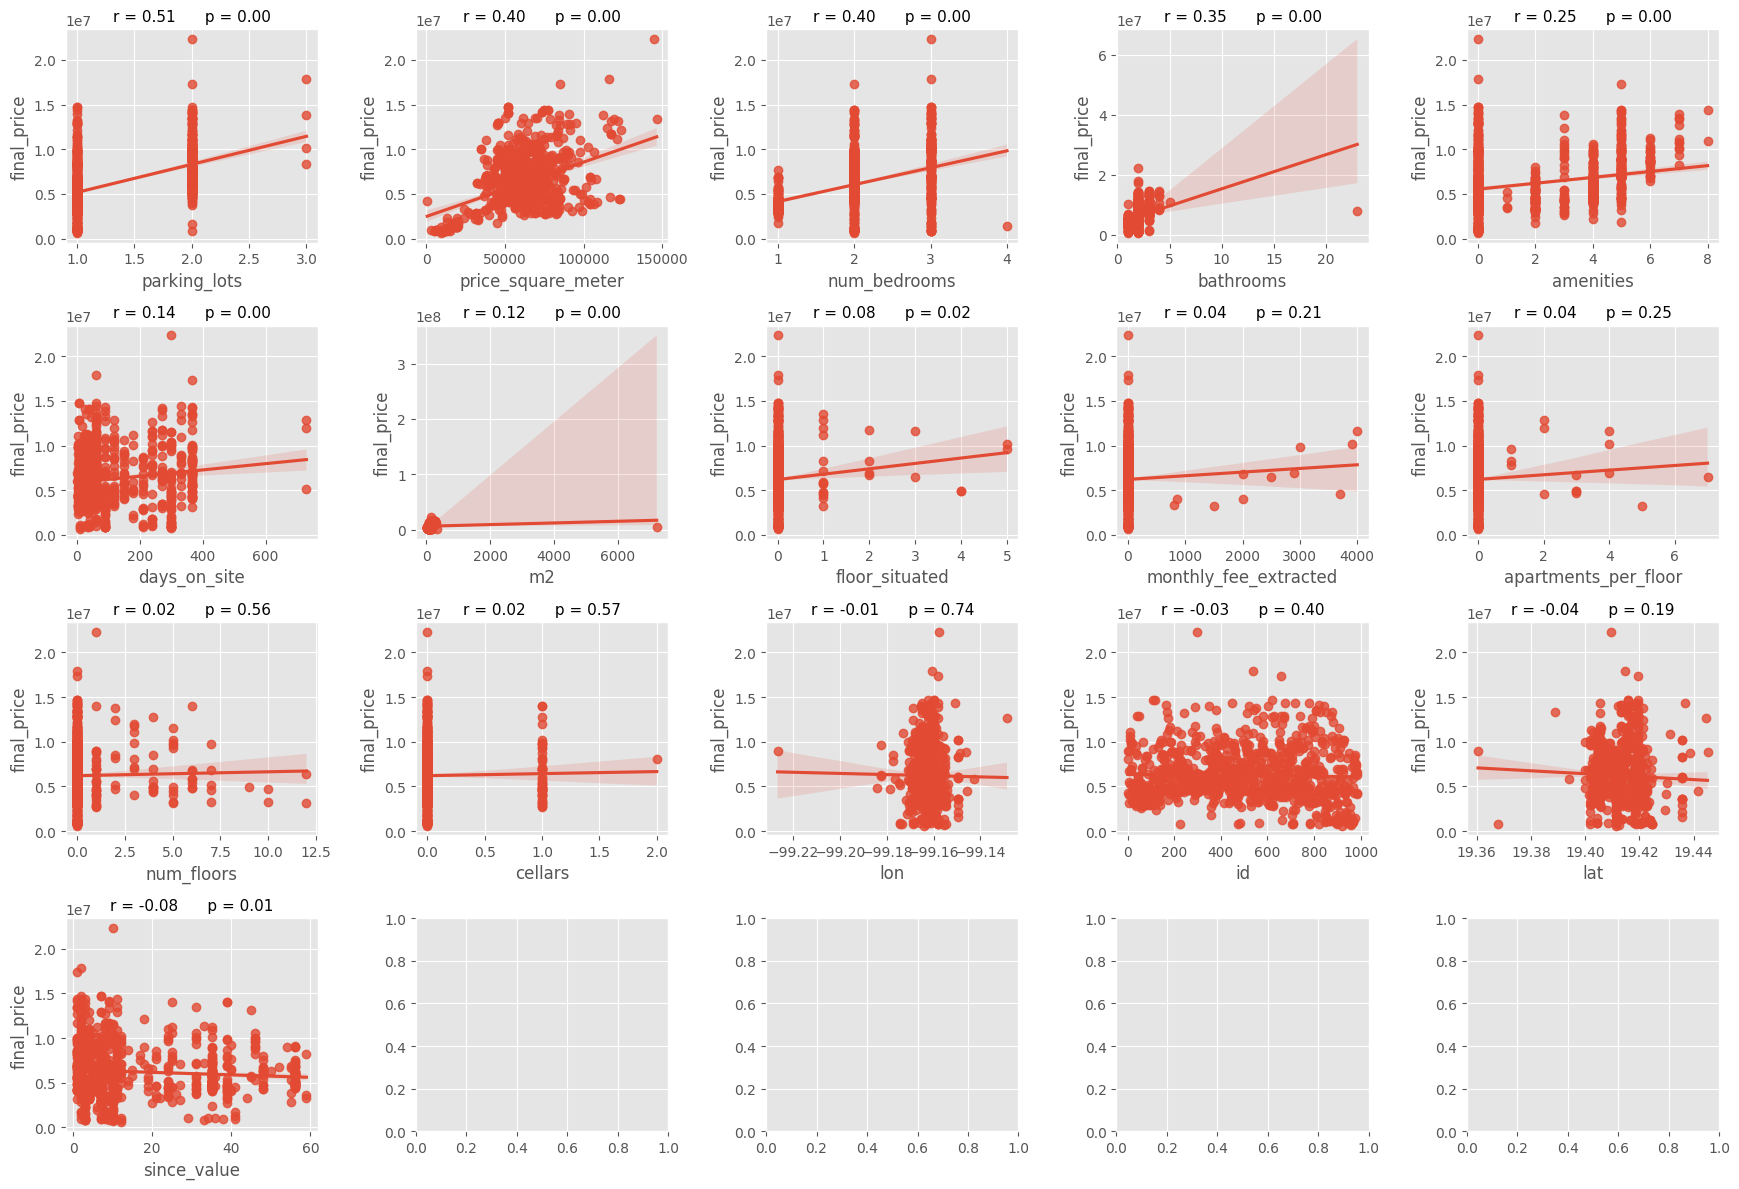

In [169]:
nr_rows = 4
nr_cols = 5

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(list_plot_num_feats):
            sns.regplot(x=df_cdmx_danue[numeric_correlations.at[i,"variable"]], y=df_cdmx_danue[target], ax = axs[r][c])
            str_title = "r = " + "{0:.2f}".format(numeric_correlations.at[i,"r"]) + "      " "p = " + "{0:.2f}".format(numeric_correlations.at[i,"p"])
            axs[r][c].set_title(str_title,fontsize=11)

plt.tight_layout()
plt.show()

In [184]:
df_cdmx_danue[numeric_correlations['variable'].tolist()]

,parking_lots,price_square_meter,num_bedrooms,bathrooms,amenities,days_on_site,m2,floor_situated,monthly_fee_extracted,apartments_per_floor,num_floors,cellars,lon,id,lat,since_value
0,2,70866.141732,2.0,2.0,3.0,5.0,127.0,0.0,0.0,0.0,1.0,0.0,-99.164182,1,19.421317,5
1,1,78962.962963,1.0,1.0,2.0,7.0,54.0,0.0,0.0,0.0,0.0,0.0,-99.163541,2,19.421029,7
2,2,49653.374233,3.0,3.0,0.0,4.0,163.0,0.0,0.0,0.0,3.0,2.0,-99.161872,3,19.407814,4
3,1,43010.752688,2.0,2.0,2.0,150.0,93.0,0.0,853.0,0.0,0.0,0.0,-99.160243,4,19.404992,5
4,1,65366.019417,2.0,2.0,4.0,52.0,103.0,0.0,0.0,0.0,0.0,0.0,-99.156036,5,19.419693,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2,45607.142857,2.0,2.0,0.0,40.0,140.0,0.0,0.0,0.0,0.0,0.0,-99.161068,981,19.405777,40
940,1,49000.000000,2.0,2.0,0.0,40.0,84.0,0.0,0.0,0.0,0.0,0.0,-99.161068,982,19.405777,40
941,1,48136.363636,2.0,2.0,0.0,40.0,88.0,0.0,0.0,0.0,0.0,0.0,-99.161068,983,19.405777,40
942,2,58071.228070,2.0,2.0,0.0,60.0,114.0,0.0,0.0,0.0,0.0,0.0,-99.160241,984,19.414845,2


In [186]:
corr_abs

,parking_lots,price_square_meter,num_bedrooms,bathrooms,amenities,days_on_site,m2,floor_situated,monthly_fee_extracted,apartments_per_floor,num_floors,cellars,lon,id,lat,since_value
parking_lots,1.000000,0.075306,0.326836,0.150323,0.368726,0.159346,0.070089,0.052179,0.025656,0.031286,0.023337,0.078682,0.027373,0.002861,0.153634,0.037967
price_square_meter,0.075306,1.000000,0.295966,0.051486,0.002702,0.039511,0.153572,0.028990,0.010980,0.016746,0.076435,0.003455,0.023308,0.130915,0.070032,0.004782
num_bedrooms,0.326836,0.295966,1.000000,0.407641,0.234754,0.100019,0.103873,0.026163,0.017404,0.009503,0.056678,0.000804,0.047395,0.132235,0.187255,0.032346
bathrooms,0.150323,0.051486,0.407641,1.000000,0.066224,0.014488,0.071455,0.029024,0.009435,0.016692,0.044878,0.044463,0.033400,0.062430,0.090617,0.032448
amenities,0.368726,0.002702,0.234754,0.066224,1.000000,0.151239,0.018812,0.124319,0.090308,0.105165,0.216236,0.204013,0.031810,0.084551,0.197185,0.064489
days_on_site,0.159346,0.039511,0.100019,0.014488,0.151239,1.000000,0.019229,0.231005,0.062005,0.206683,0.135525,0.021937,0.045144,0.315493,0.008560,0.319020
m2,0.070089,0.153572,0.103873,0.071455,0.018812,0.019229,1.000000,0.006718,0.000905,0.000324,0.012656,0.002116,0.013410,0.016787,0.041943,0.044160
floor_situated,0.052179,0.028990,0.026163,0.029024,0.124319,0.231005,0.006718,1.000000,0.446590,0.729691,0.447341,0.152311,0.018764,0.116345,0.044765,0.074731
monthly_fee_extracted,0.025656,0.010980,0.017404,0.009435,0.090308,0.062005,0.000905,0.446590,1.000000,0.637986,0.372250,0.172319,0.028563,0.026258,0.032299,0.016650
apartments_per_floor,0.031286,0.016746,0.009503,0.016692,0.105165,0.206683,0.000324,0.729691,0.637986,1.000000,0.531369,0.089877,0.019915,0.068079,0.033512,0.056612


In [190]:
numeric_correlations['variable'].tolist()

['parking_lots',
 'price_square_meter',
 'num_bedrooms',
 'bathrooms',
 'amenities',
 'days_on_site',
 'm2',
 'floor_situated',
 'monthly_fee_extracted',
 'apartments_per_floor',
 'num_floors',
 'cellars',
 'lon',
 'id',
 'lat',
 'since_value']

In [195]:
corr_list = ['parking_lots',
 'price_square_meter',
 'num_bedrooms',
 'bathrooms',
 'amenities',
 'days_on_site',
 'm2',
 'floor_situated',
 'monthly_fee_extracted',
 'apartments_per_floor',
 'num_floors',
 'cellars',
 'lon',
 'id',
 'lat',
 'since_value',
 'final_price']

In [198]:
# Correlation coefficient threshold
min_val_corr = 0.14

corr = df_cdmx_danue[corr_list].corr()
corr_abs = corr.abs()

nr_num_cols = len(numeric_correlations)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [199]:
print(ser_corr)
print("*"*50)
print(f"List of numerical features with r above {min_val_corr}:")
print(cols_abv_corr_limit)
print("*"*50)
print(f"List of numerical features with r below {min_val_corr}:")
print(cols_bel_corr_limit)

final_price              1.000000
parking_lots             0.514746
price_square_meter       0.399123
num_bedrooms             0.396804
bathrooms                0.348847
amenities                0.247312
days_on_site             0.139589
m2                       0.121255
since_value              0.080244
floor_situated           0.075724
lat                      0.042707
monthly_fee_extracted    0.040539
apartments_per_floor     0.037762
id                       0.027166
num_floors               0.019009
cellars                  0.018377
Name: final_price, dtype: float64
**************************************************
List of numerical features with r above 0.14:
['final_price', 'parking_lots', 'price_square_meter', 'num_bedrooms', 'bathrooms', 'amenities']
**************************************************
List of numerical features with r below 0.14:
['days_on_site', 'm2', 'since_value', 'floor_situated', 'lat', 'monthly_fee_extracted', 'apartments_per_floor', 'id', 'num_floors', 

# Conclusion numerical coulmns EDA:

We see that for features like 'parking_lots' there is a slightly linear correlation (0.51) to the price.
For other features such as 'mnthly_fee_extracted' the correlation is very weak.
For this use case I'll use features that have a correlation coeficient larger than a certain arbitrary threshold value to 'final_price'.
This threshold will be set at 0.14

In [ ]:
df_cdmx_danue.dtypes[df_cdmx_danue.dtypes == "object"].index

In [179]:
categorical_feats = ['disposition',
       'orientation', 'department_type', 'nom_agem', 'ageb_id', 'agem_id', 'conveniency_shop', 'pharmacy', 'recreative_installation',
       'retailshop', 'schools', 'supermarket', 'wholesale']

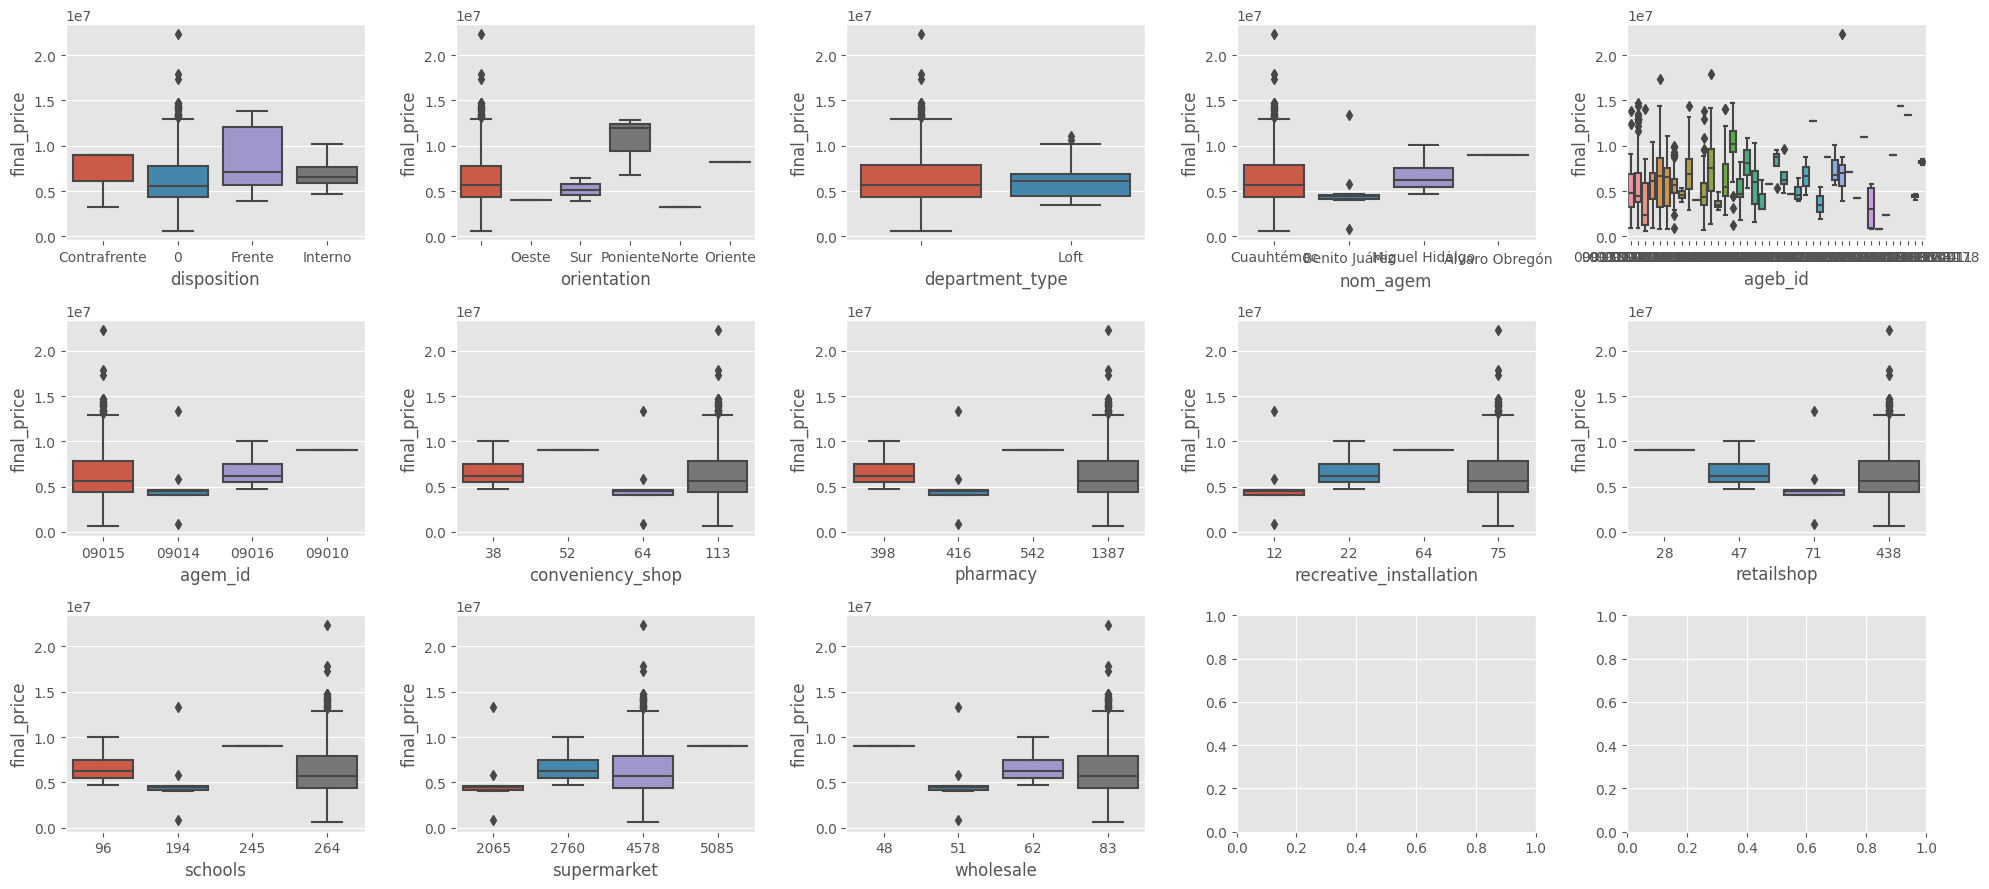

In [180]:
li_cat_feats = list(categorical_feats)
nr_rows = 3
nr_cols = 5
target = "final_price"

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_cdmx_danue, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

# Categorical columns EDA (incl. INEGI)

For some of the categorical variables there is no strong corr to the target.
Yet, some features are are easy to find a slightly strong correlation.
From the figures above, these are: disposition, orientation, department type, nom_agem (alcaldia), ageb_id
Nevertheless, all variables will be used in the ML method

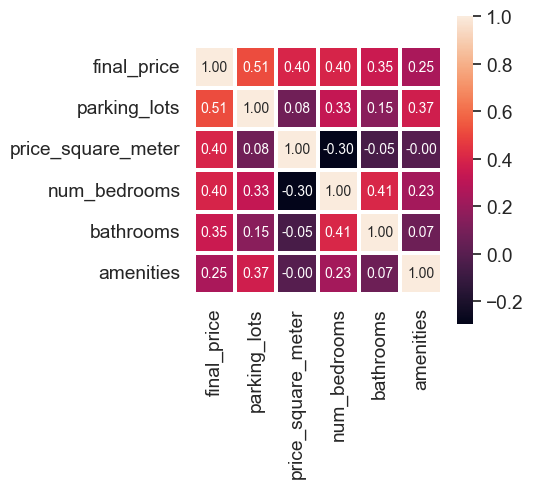

In [202]:
def plot_corr_matrix(df, nr_c, targ):
    """
    Plot correlation matrix
    """
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_cdmx_danue[corr_list], nr_feats, target)

# Data Wrangling

In [271]:
df_cdmx_pcavars = df_cdmx_danue[['final_price', 'days_on_site','bathrooms','cellars','num_floors',
               'monthly_fee_extracted','apartments_per_floor','parking_lots',
              'floor_situated','num_bedrooms',
              'm2','ageb_id','conveniency_shop',
              'pharmacy','recreative_installation','retailshop','schools','supermarket','wholesale']]

In [272]:
# Create X and y variables for Principal Component Analysis
X = df_cdmx_pcavars
y = df_cdmx_danue['final_price']

In [237]:
X.describe()

,final_price,days_on_site,bathrooms,cellars,num_floors,monthly_fee_extracted,apartments_per_floor,parking_lots,floor_situated,num_bedrooms,m2
count,9.440000e+02,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,6.220946e+06,101.537076,1.977754,0.056144,0.307203,28.777542,0.047669,1.332627,0.048729,2.096398,112.521727
std,2.927177e+06,116.390185,0.895691,0.234881,1.280787,290.163729,0.425655,0.480318,0.368077,0.612894,235.900435
min,6.342170e+05,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,31.000000
25%,4.369000e+06,31.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,75.000000
50%,5.653287e+06,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,93.000000
75%,7.860470e+06,120.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,129.250000
max,2.233000e+07,730.000000,23.000000,2.000000,12.000000,4000.000000,7.000000,3.000000,5.000000,4.000000,7210.000000


In [238]:
y.describe()

count    9.440000e+02
mean     6.220946e+06
std      2.927177e+06
min      6.342170e+05
25%      4.369000e+06
50%      5.653287e+06
75%      7.860470e+06
max      2.233000e+07
Name: final_price, dtype: float64

<Axes: xlabel='final_price', ylabel='Count'>

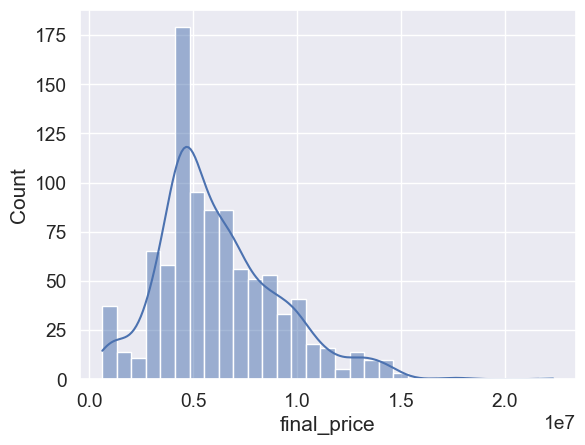

In [240]:
sns.histplot(y, kde=True)

In [241]:
y.skew()

0.8758214648426219

# numerical variable distribution and statistical properties with plots

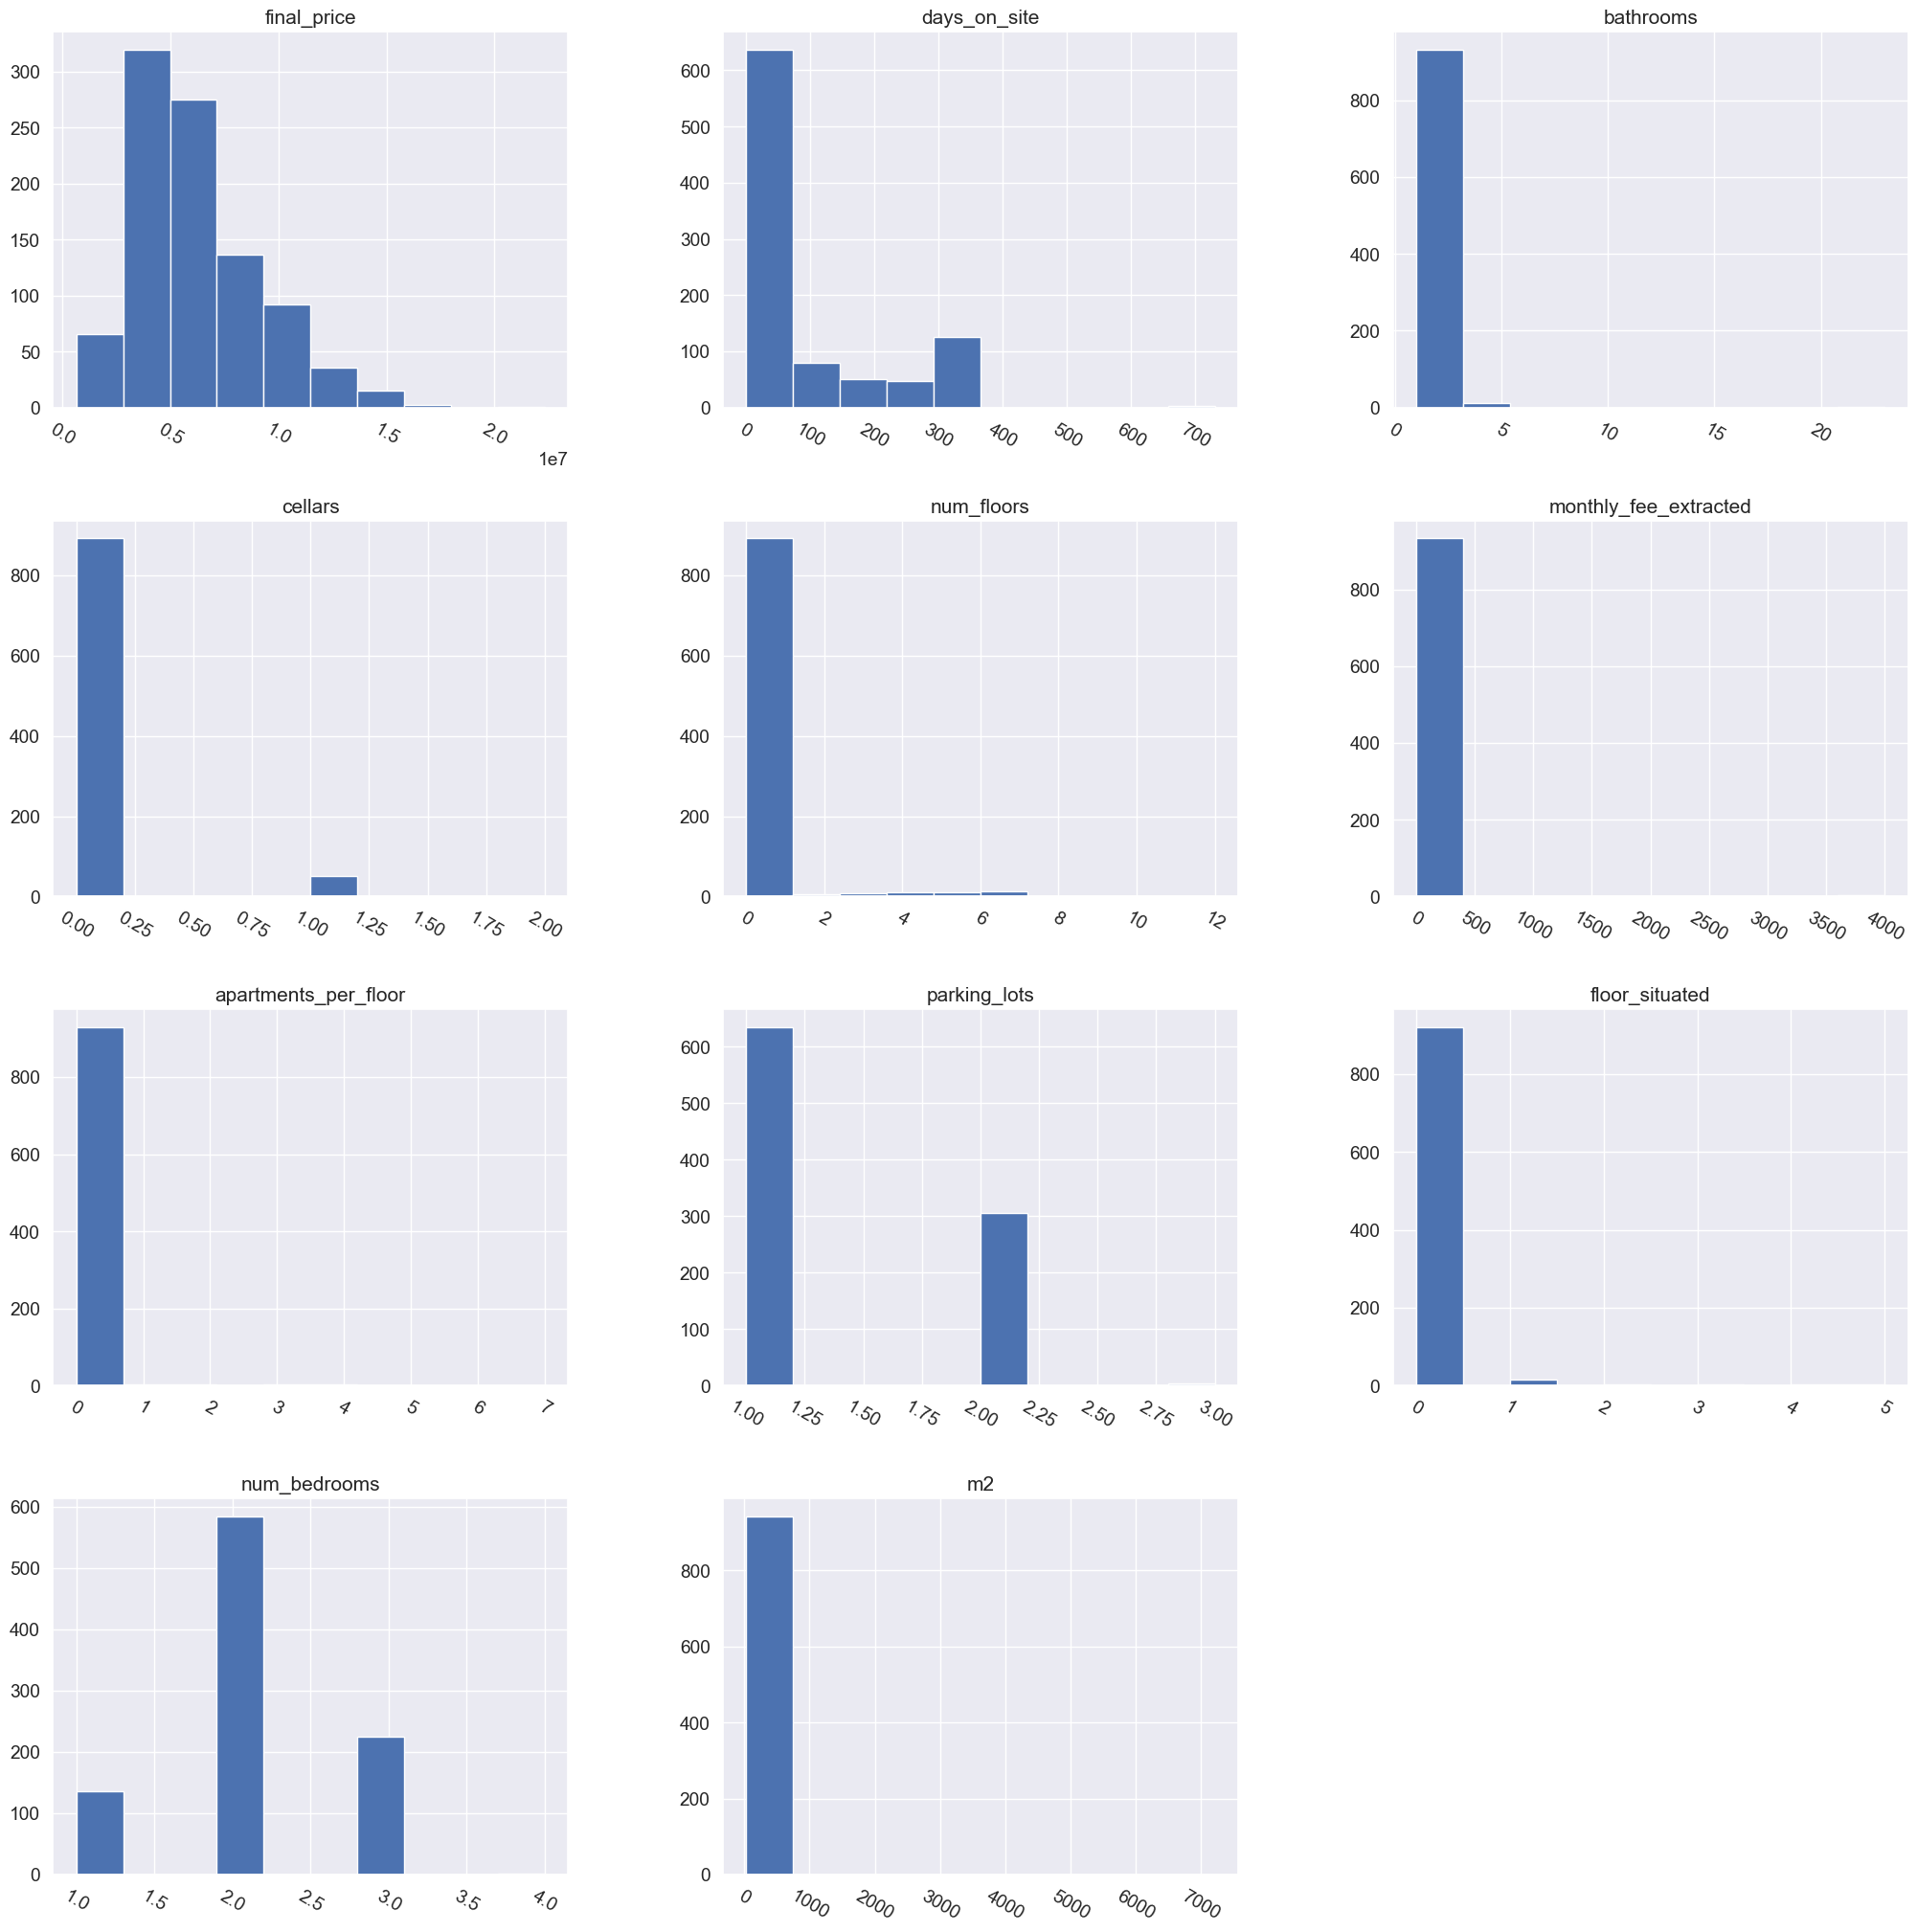

In [242]:
X.hist(figsize=(25,25), xrot=-30)
plt.show()

<Axes: >

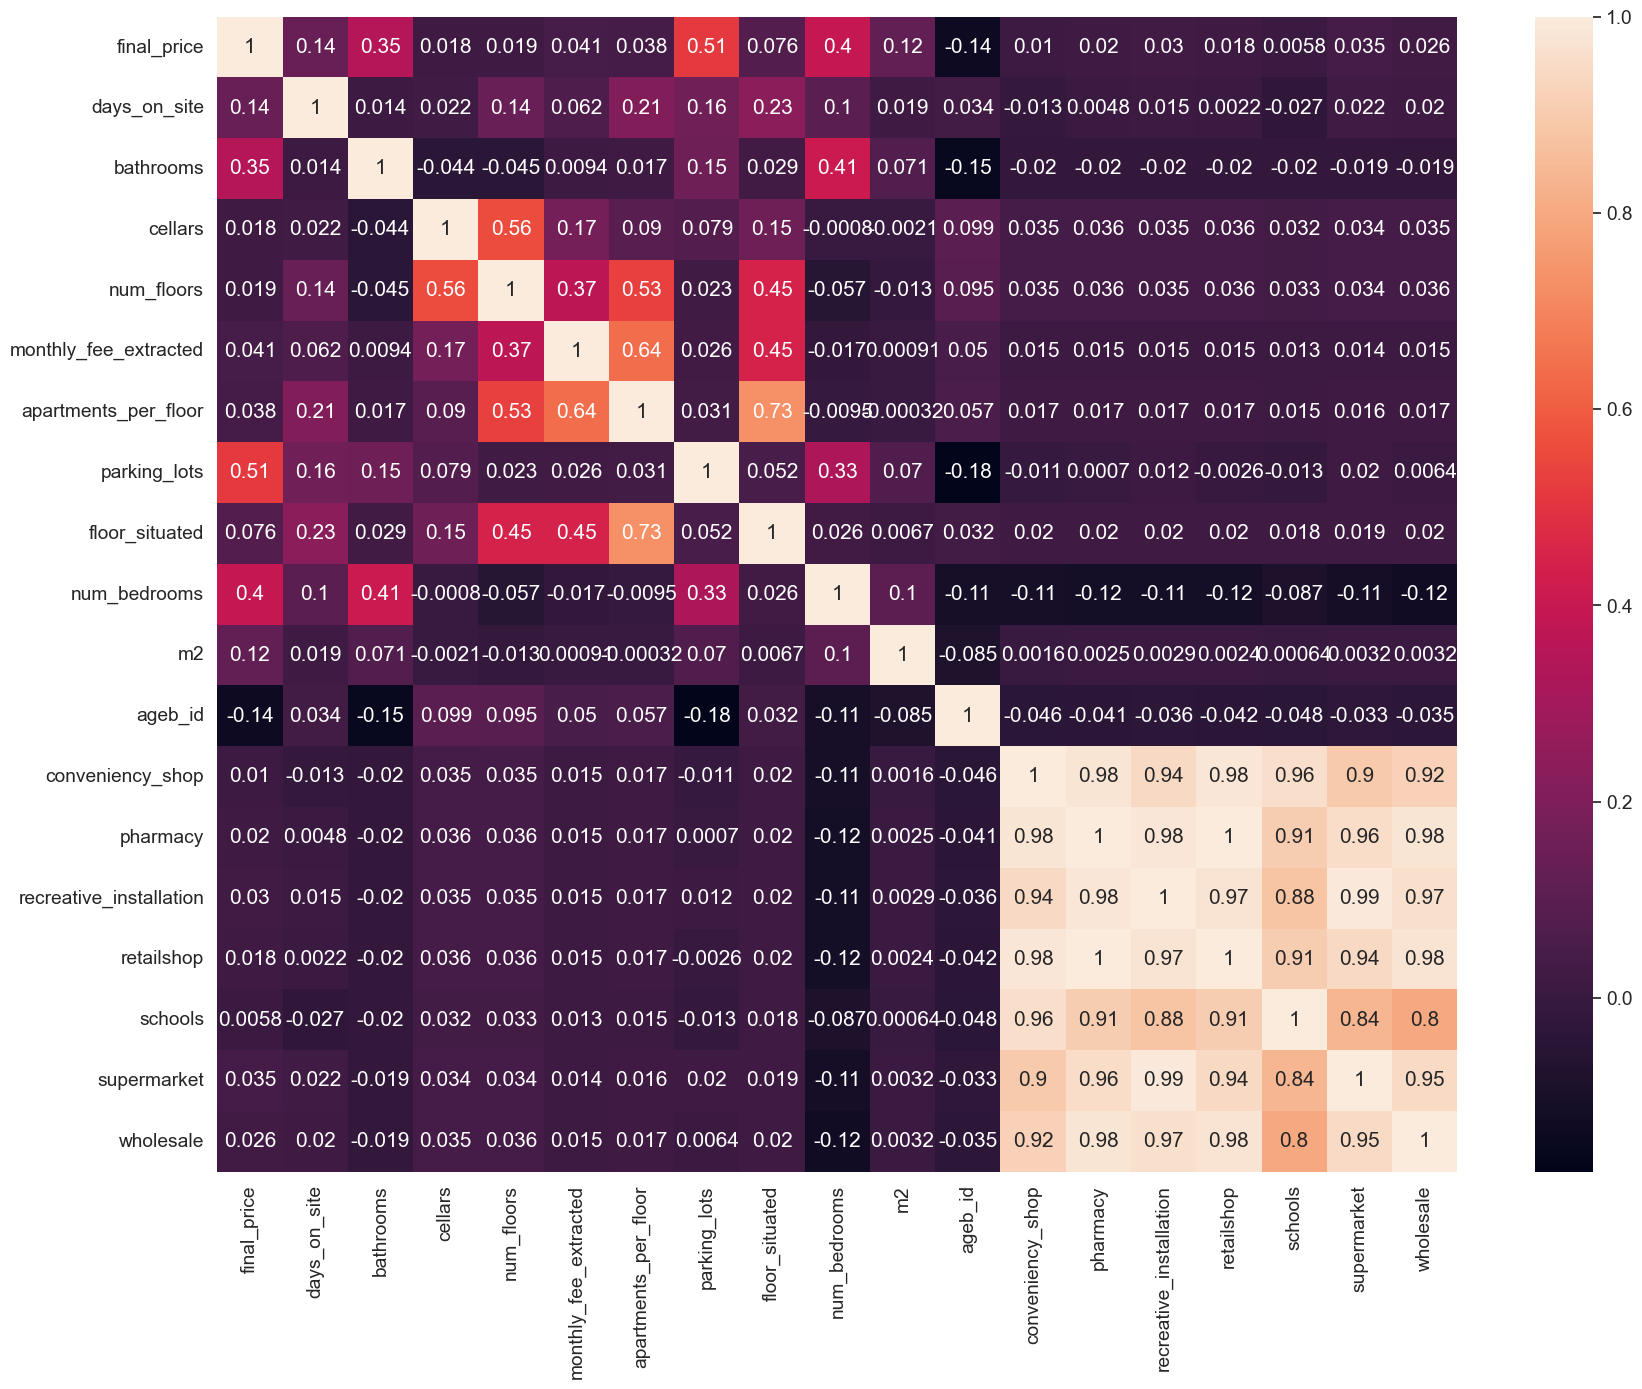

In [243]:
plt.figure(figsize = (20,15)) 
sns.heatmap(X.corr(),annot = True)

# PCA Code

In [295]:
X = df_cdmx_pcavars


In [296]:
# Standardize the data
X = X.drop(columns=['final_price'])
scaler = StandardScaler()
scaler.fit(X)
data_standardized = scaler.transform(X)

In [297]:
pca = PCA(n_components=2)
pca.fit(data_standardized,y)
x_new = pca.transform(X.values)   

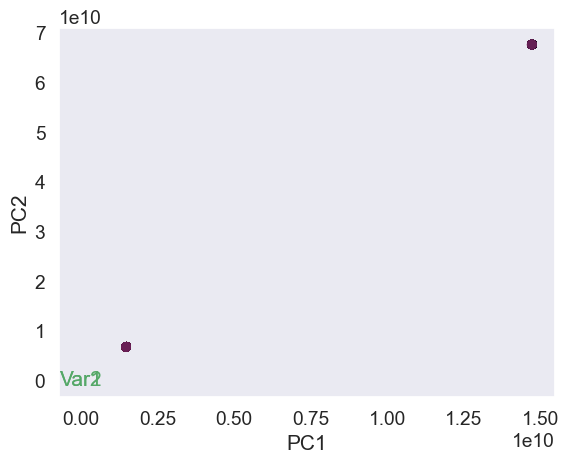

In [298]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(x_new[:,0:2], pca.components_) 
plt.show()

In [299]:
n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [303]:
initial_feature_names = X.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

df_components = pd.DataFrame(dic.items())

In [304]:
df_components

,0,1
0,PC0,pharmacy
1,PC1,apartments_per_floor


# So on the PC1 the feature named pharmacy is the most important and on PC2 the apartments_per_floor.

In [276]:
#explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# principal components
principal_components = pca.components_
